In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import os
import numpy as np
from torchinfo import summary
from torch.utils.data.dataloader import DataLoader
#from torch.data import random_split
from torchvision import transforms
from Convs_Unet import UNet

In [2]:
from platform import python_version

print(python_version())

3.10.11


In [3]:
from torch.utils.data import random_split

In [4]:
#pip install tqdm 



In [5]:
from tqdm.notebook import trange, tqdm

In [8]:
model = UNet(n_channels = 3 , n_classes = 1)
print("Loading Unet model")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")
model.to(device=device)
model.load_state_dict(torch.load("../Tiles_512_Sigmod6CT_ep150.pth", map_location=device))
print("model loaded")

Loading Unet model
Using device cuda
model loaded


In [18]:
trainable = {"inc" : False , "down1" : False}


In [19]:
for k in model.named_parameters():
    k[1].requires_grad = False if k[0].split(".")[0] in trainable else True

In [11]:
for k in model.named_parameters():
    print(k[0] ," : ", k[1].shape , " : " , k[1].requires_grad)

inc.double_conv.0.weight  :  torch.Size([64, 3, 3, 3])  :  False
inc.double_conv.0.bias  :  torch.Size([64])  :  False
inc.double_conv.1.weight  :  torch.Size([64])  :  False
inc.double_conv.1.bias  :  torch.Size([64])  :  False
inc.double_conv.3.weight  :  torch.Size([64, 64, 3, 3])  :  False
inc.double_conv.3.bias  :  torch.Size([64])  :  False
inc.double_conv.4.weight  :  torch.Size([64])  :  False
inc.double_conv.4.bias  :  torch.Size([64])  :  False
down1.maxpool_conv.1.double_conv.0.weight  :  torch.Size([128, 64, 3, 3])  :  False
down1.maxpool_conv.1.double_conv.0.bias  :  torch.Size([128])  :  False
down1.maxpool_conv.1.double_conv.1.weight  :  torch.Size([128])  :  False
down1.maxpool_conv.1.double_conv.1.bias  :  torch.Size([128])  :  False
down1.maxpool_conv.1.double_conv.3.weight  :  torch.Size([128, 128, 3, 3])  :  False
down1.maxpool_conv.1.double_conv.3.bias  :  torch.Size([128])  :  False
down1.maxpool_conv.1.double_conv.4.weight  :  torch.Size([128])  :  False
down1.ma

In [12]:
summary(model)

Layer (type:depth-idx)                        Param #
UNet                                          --
├─DoubleConv: 1-1                             --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       (1,792)
│    │    └─BatchNorm2d: 3-2                  (128)
│    │    └─ReLU: 3-3                         --
│    │    └─Conv2d: 3-4                       (36,928)
│    │    └─BatchNorm2d: 3-5                  (128)
│    │    └─ReLU: 3-6                         --
├─DownConv: 1-2                               --
│    └─Sequential: 2-2                        --
│    │    └─MaxPool2d: 3-7                    --
│    │    └─DoubleConv: 3-8                   (221,952)
├─DownConv: 1-3                               --
│    └─Sequential: 2-3                        --
│    │    └─MaxPool2d: 3-9                    --
│    │    └─DoubleConv: 3-10                  886,272
├─DownConv: 1-4                               --
│    └─Sequential: 2-4             

In [5]:
class Data_from_disk(torch.utils.data.Dataset) :
    def __init__(self , tag = 0 , dir_ = "../Data/Full_Aug/"): #tag indicates the type of input image to be trained on 
        super().__init__()
        self.tag = tag 
        self.dir_ = dir_
        self.inp_dir = sorted([x for x in os.listdir(dir_ + "Im_inp/") if x.split("_")[2] == str(tag)])
        self.out_dir = sorted(os.listdir(dir_ + "Im_out/"))
    def __getitem__(self , idx):
        #print(self.inp_dir[idx] , self.out_dir[idx])
        #assert self.inp_dir[idx] == self.out_dir[idx] , f"names dont match . given names are {self.inp_dir[idx]} and {self.out_dir[idx]}"
        #assert self.inp_dir[idx].split("_")[2] == str(self.tag) , f"tags are different , required : {self.tag} , found : {self.inp_dir[idx].split('_')[2]}"
        x1 = np.array(Image.open(self.dir_ + "Im_inp/" + self.inp_dir[idx]))
        x2 = np.array(Image.open(self.dir_ + "Im_out/" + self.out_dir[idx]))[:,:,0:1]
        x1 = np.transpose(x1 ,(2, 0, 1))
        x2 = np.transpose(x2 ,(2, 0, 1))
        x1 = x1/255
        x2 = x2/255
        #if return_names :
        #return (torch.from_numpy(x1) , torch.from_numpy(x2)) , (self.inp_dir[idx] ,self.out_dir[idx] )
        return (torch.from_numpy(x1) , torch.from_numpy(x2))
    
    def __len__(self):
        return (len(self.inp_dir))    

In [33]:
#Plan is to train three different models on the training data of three tags and use their ensemble

In [18]:
dd = Data_from_disk(tag = 0)

In [19]:
len(dd.inp_dir) 

37325

In [20]:
len(dd.out_dir)

37325

In [7]:
for x , y in dd :
    print( " =>" ,y[0] , y[1])
    #print([y1 for i ,y1 in enumerate(y[0].split("_")) if i != 2] , [y1 for i ,y1 in enumerate(y[1].split("_")) if i != 2])
    #assert 1 == 2 , "1 is not equal to 2"
    assert tuple([y1 for i ,y1 in enumerate(y[0].split("_")) if i != 2]) == tuple([y1 for i ,y1 in enumerate(y[1].split("_")) if i != 2]) , f" yes yes yes !!! => {y[0] , y[1]}"

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [5]:
g1 = torch.Generator().manual_seed(42)
train_ds , val_ds , test_ds = random_split(Data_from_disk(tag = 2) , [0.7 , 0.2 ,0.1] , generator = g1)

In [6]:
len(train_ds) , len(val_ds) , len(test_ds)

(359, 102, 51)

In [7]:
batch = 3

In [8]:
train_loader = DataLoader(train_ds , batch , shuffle = True)
val_loader = DataLoader(val_ds , batch)
test_loader = DataLoader(test_ds , batch)

In [9]:
for x , y in train_loader:
    print(x.shape , y.shape)
    break

torch.Size([3, 3, 512, 512]) torch.Size([3, 1, 512, 512])


In [20]:
EPOCHS = 100
lr = 0.01

In [13]:
def evaluate(model , val_loader ,loss_func ):
    curr_val_loss = 0
    with torch.no_grad() :
        for i ,mm in enumerate(val_loader):
            x = mm[0]
            y = mm[1]
            x = x.to(device , dtype = torch.float32)
            y = y.to(device , dtype = torch.float32)
            loss = loss_func(torch.sigmoid(model(x)), y)
            curr_val_loss = (curr_val_loss*(i) + loss)/(i+1)
    return curr_val_loss        

In [22]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss*(self.min_delta + 1)):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False   

In [23]:
#from collections import deque
early_stopper = EarlyStopper(patience = 3 , min_delta = 0.05)
def fit(model , epochs , lr , train_loader , val_loader , opt_func , loss_func ):
    #Q = deque()
    history = []
    optimizer = opt_func(model.parameters() , lr)
    cur_val_loss = 0
    scheduler =  torch.optim.lr_scheduler.ExponentialLR(optimizer , gamma = 0.95 , verbose = True)
    for epoch in trange(epochs , total = epochs , desc="num_epochs") :
        iterator = tqdm(enumerate(train_loader) , total = len(train_loader) ,desc="num_batches") 
        for i ,mm in iterator:
            x = mm[0]
            y = mm[1]
            x = x.to(device , non_blocking = True , dtype = torch.float32)
            y = y.to(device , non_blocking = True , dtype = torch.float32)
            #scheduler.print_lr()
            #print(x.device , y.device)
            optimizer.zero_grad()
            #print("zero_grad")
            loss = loss_func(torch.sigmoid(model(x)), y)
            #print("calc_loss")
            iterator.set_postfix(train_loss = loss.item())
            loss.backward()
            optimizer.step()
            
            #torch.cuda.empty_cache()
        scheduler.step()    
        val_err = evaluate(model , val_loader , loss_func)
        curr_train_loss = evaluate(model , train_loader , loss_func)
        print(f"train_loss : {curr_train_loss}  , val_loss : {val_err}")
        history.append((curr_train_loss , val_err ))
        #if len(Q) == 3 :
        #    Q.popleft()
        #Q.append(model.parameters())
        if early_stopper.early_stop(val_err) :
            #model.parameters() = Q[0]
            break
            
    return history        
            

In [24]:
fit_dic1 = {"model" : model ,
           "epochs" : EPOCHS ,
           "lr" : lr ,
           "train_loader" : train_loader ,
           "val_loader" : val_loader ,
           "opt_func" : torch.optim.Adam  ,
           "loss_func" : torch.nn.functional.binary_cross_entropy}

In [25]:
history = fit(**fit_dic1)

Adjusting learning rate of group 0 to 1.0000e-02.


num_epochs:   0%|          | 0/100 [00:00<?, ?it/s]

num_batches:   0%|          | 0/120 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
history = [
    ( 0.5210024118423462 ,0.5415207743644714 ) ,
     (0.37361085414886475  , 0.3805997371673584) ,
    ( 0.3381986916065216 , 0.339740514755249) ,
    ( 0.32221803069114685  ,0.33410415053367615) ,
    (0.30377575755119324  , 0.31469979882240295) ,
    (0.2808768153190613  , 0.29126814007759094) ,
    ( 0.25920480489730835  , 0.27106329798698425) ,
    ( 0.2549086809158325  ,0.2616758644580841) ,
    ( 0.23865899443626404  , 0.2510315775871277) ,
    ( 0.23417545855045319  , 0.2460983246564865) ,
    (0.22503270208835602  , 0.2377868890762329) ,
    ( 0.21796520054340363  ,0.23058636486530304) ,
    ( 0.2164277732372284  , 0.22869761288166046) ,
    (0.2067599892616272  , 0.21845845878124237) ,
    ( 0.2017686665058136  ,0.21408507227897644) ,
    ( 0.19680079817771912  ,0.20915335416793823) ,
    ( 0.19197140634059906  ,0.2042969912290573) ,
    (0.18900370597839355  , 0.20124824345111847) ,
    (0.18398010730743408  , 0.19592618942260742) ,
    ( 0.18092457950115204  ,0.19178570806980133) ,
    ( 0.17566199600696564  ,0.1873977780342102) ,
    (0.17368613183498383  ,0.18448972702026367) ,
    ( 0.17041553556919098  ,0.18076074123382568) ,
    (0.16659367084503174  , 0.17802855372428894) ,
    (0.1650014966726303  , 0.17631404101848602) ,
    (0.16272717714309692  ,0.1738252490758896) ,
    ( 0.161124125123024  ,0.1729673445224762) ,
    (0.15711753070354462  ,0.16847681999206543) ,
    (0.15637090802192688  ,0.16700361669063568) ,
    (0.15387485921382904  ,0.16456814110279083) ,
    ( 0.15266869962215424  , 0.1642063856124878) ,
    (0.1505383998155594  , 0.16142769157886505) ,
    (0.14993791282176971  ,0.16114754974842072) ,
    (0.14768773317337036  ,0.15892399847507477) ,
    ( 0.14660419523715973  ,0.15799273550510406) ,
    (0.14452986419200897  , 0.15613628923892975) ,
    (0.14409728348255157  , 0.15502943098545074) ,
    (0.14233002066612244  ,0.1538487672805786) ,
    (0.1415640413761139  ,0.153089702129364) ,
    (0.14135488867759705  ,0.15225636959075928),
    ( 0.13975629210472107  ,0.15124383568763733) ,
    ( 0.138702854514122  , 0.14973755180835724) ,
    (0.13779814541339874  , 0.14894606173038483) ,
    (0.13808438181877136  , 0.1489797979593277) ,
    ( 0.13657160103321075  , 0.14770711958408356) ,
    (0.13529792428016663  , 0.14711229503154755) ,
    (0.13676609098911285  , 0.14703050255775452) ,
    (0.13406281173229218  , 0.14589524269104004) ,
    (0.1338396817445755  ,0.14553962647914886) ,
    (0.13314281404018402  ,0.14446115493774414) ,
    (0.1323171854019165  , 0.1439349353313446) ,
    (0.13254088163375854  ,0.1438038945198059) ,
    (0.1317215859889984  ,0.1429009586572647) ,
    (0.13140587508678436  , 0.1425641030073166) ,
    (0.13069729506969452  , 0.14190657436847687) ,
    (0.1308678239583969  , 0.14169836044311523) ,
    ( 0.13044288754463196  , 0.1411549299955368) ,
    (0.12984918057918549  ,0.14135625958442688) ,
    (0.1295296996831894  , 0.14071372151374817) ,
    (0.12917736172676086  , 0.14029210805892944) ,
    (0.12886984646320343  , 0.1400974541902542) ,
    ( 0.12797869741916656  , 0.1398223489522934) ,
    ( 0.12761445343494415  , 0.1391971856355667) ,
    ( 0.12803025543689728  , 0.13896559178829193) ,
    ( 0.12749332189559937  , 0.13881011307239532) ,
    ( 0.12762802839279175  , 0.13851235806941986) ,
    (0.127237007021904  , 0.13846443593502045) ,
    (0.12639814615249634  ,0.13812924921512604) ,
    (0.12687072157859802  ,0.1378898024559021) ,
    (0.12599767744541168  , 0.1376795768737793) ,
    (0.12603312730789185  , 0.13755148649215698) ,
    (0.12580104172229767  , 0.13738781213760376) ,
    ( 0.1254911720752716  , 0.13722293078899384) ,
    (0.1256779283285141  , 0.13709820806980133) ,
    ( 0.12551908195018768  , 0.13689236342906952) ,
    (0.12511907517910004  , 0.13676908612251282) ,
    ( 0.12503066658973694  , 0.13668064773082733) ,
    (0.12548232078552246  , 0.13655884563922882) ,
    (0.12473141402006149  , 0.13638117909431458) ,
    (0.1250576227903366  , 0.13637904822826385) ,
    ( 0.1255665123462677  , 0.136102557182312) ,
    (0.12493149936199188  , 0.1360814869403839) ,
    ( 0.12458065152168274  , 0.1359986513853073) ,
    (0.12497865408658981  ,0.13582144677639008) ,
    (0.12391338497400284  , 0.1356729120016098) ,
    ( 0.12474419176578522  , 0.13563205301761627) ,
    (0.12438002973794937  ,0.13559696078300476) ,
    (0.12405958026647568  ,0.13554304838180542) ,
    (0.12433642148971558  ,0.1354302018880844) ,
    ( 0.12362366914749146  , 0.13536261022090912) ,
    (0.12423388659954071  , 0.13521264493465424) ,
    (0.12379083037376404  , 0.1351424604654312) ,
    ( 0.12341891974210739  , 0.13516487181186676) ,
    (0.12392546236515045  , 0.13501793146133423) ,
    (0.12352608144283295  , 0.1349979192018509) ,
    (0.1236729770898819  , 0.13497962057590485) ,
    (0.12392865866422653  , 0.13491302728652954) ,
    (0.12305524945259094  , 0.13488347828388214) ,
    (0.12349066883325577  , 0.13495823740959167) ,
    ( 0.12355033308267593  ,0.13485899567604065)
     
]

In [3]:
import matplotlib.pyplot as plt 


In [7]:
print(len(his1))

100


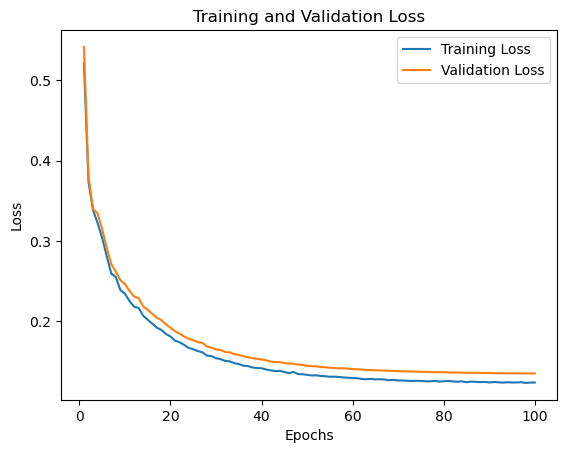

In [11]:
# Plot and label the training and validation loss values
plt.plot(range(1 ,len(his1)+1),his1 , label='Training Loss')
plt.plot(range(1 ,len(his2)+1), his2, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
#plt.xticks(arange(0, len(his1), 2))
 
# Display the plot
plt.legend(loc='best')
plt.savefig("../graphs/model1.png")
plt.show()

In [10]:
model = UNet(n_channels = 3 , n_classes = 1)
print("Loading Unet model")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")
model.to(device=device)
model.load_state_dict(torch.load("model3.pth", map_location=device))
print("model loaded")

Loading Unet model
Using device cuda
model loaded


In [11]:
for x , y in test_loader :
    print(x.shape , y.shape)
    break

torch.Size([3, 3, 512, 512]) torch.Size([3, 1, 512, 512])


In [12]:
test_ds[0][0].shape , test_ds[0][1].shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

In [14]:
evaluate(model , test_loader ,torch.nn.functional.binary_cross_entropy )

tensor(0.2340, device='cuda:0')

In [15]:
def check(img , threshold ,model):
    """
    img => torch tensor
    out => numpy image
    """
    
    img = torch.unsqueeze(img , 0)
    img = img.to(device=device, dtype=torch.float32)
    print(img.shape)
    with torch.no_grad():
        out_img = torch.sigmoid(model(img))
        out_img = out_img.squeeze().cpu().numpy()
    print(out_img.shape)    
    return out_img    
        

In [16]:
img = check(test_ds[0][0] , 1 , model)

torch.Size([1, 3, 512, 512])
(512, 512)


In [18]:
test_ds[0][1].numpy()

numpy.ndarray

In [ ]:
test_ds[0][1].numpy()

In [13]:
img1 = img > 0.5

In [14]:
img1.astype(int)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1]])

In [45]:
img1 = test_ds[0][1].squeeze().numpy().astype(int)

In [46]:
img1.shape

(512, 512)

In [47]:
img1*255

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

In [48]:
import PIL
img1 = PIL.Image.fromarray(img1*255)
if img1.mode != "RGB" :
    img1 = img1.convert("RGB")
img1.save("imm2.png")    

In [ ]:
test_ds[0][1]

In [ ]:
plt.imshow(img1.astype(int) , cmap = "gray")

In [1]:
import numpy as np

In [9]:
m = np.loadtxt("history2.csv" , dtype = "str")

In [10]:
m1 = [x.split(",") for x in m]

In [11]:
m1 = [(float(x) , float(y)) for x,y in m1]

In [12]:
his1 ,his2 = list(zip(*m1))

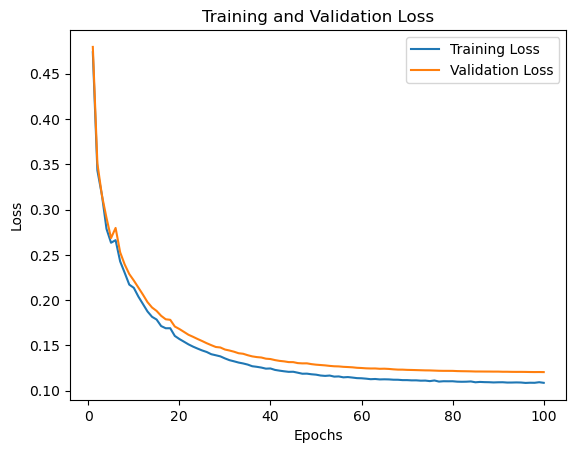

In [13]:
import matplotlib.pyplot as plt 
# Plot and label the training and validation loss values
plt.plot(range(1 ,len(his1)+1),his1 , label='Training Loss')
plt.plot(range(1 ,len(his2)+1), his2, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
#plt.xticks(arange(0, len(his1), 2))
 
# Display the plot
plt.legend(loc='best')
plt.savefig("../graphs/model2.png")
plt.show()

In [17]:
import PIL
from torchvision.transforms import ToPILImage

In [19]:
test_ds[0][0].shape

torch.Size([3, 512, 512])

In [26]:
img = ToPILImage()(test_ds[2][1])
img.show()

In [27]:
img1 = check(test_ds[2][0] , 1 , model)
img1 = img1 > 0.75
img1 = ToPILImage()(img1.astype(int)*255)
img1.show()

torch.Size([1, 3, 512, 512])
(512, 512)
